# Setup

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import zscore
%matplotlib inline

In [9]:
code_dir=Path.cwd()
project_dir=code_dir.parent
thickness_dir=project_dir/"cat_age_thickness"
input_dir=project_dir/"input"
output_dir=project_dir/"output"
tmp_dir=project_dir/"tmp"

In [10]:
atlas_resolution=400

# Load beta as provided by CAT12 statistics

In [12]:
thickness_data_array=nib.load(thickness_dir/"beta_0002.gii").darrays[0]
thickness_beta=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_dir/"beta_0002.dat", data=None, mmap=False)

# $\beta$: surface to parcel

In [13]:
from enigmatoolbox.utils.parcellation import surface_to_parcel, parcel_to_surface
from statsmodels.stats.multitest import multipletests

# Parcellate vertexwise data
thickness_beta_schaefer = surface_to_parcel(thickness_beta, f'schaefer_{atlas_resolution}_conte69')[1:]

# Visualize $\beta$

In [ ]:
from neuromaps.datasets import fetch_fslr

surfaces = fetch_fslr(density='32k')
lh, rh = surfaces['inflated']

/home/marvin/miniconda3/envs/brainstat/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


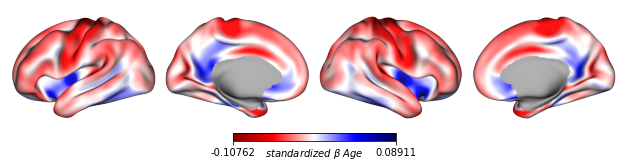

In [12]:
from surfplot import Plot

orig_map=plt.cm.get_cmap('seismic')
reversed_map = orig_map.reversed()

p = Plot(surf_lh=lh, surf_rh=rh, size=(1000,200), layout="row")
sulc_lh, sulc_rh = surfaces['sulc']
p.add_layer(thickness_beta_fdr_sig, cmap=reversed_map)
cbar_kws = dict(pad=.02, n_ticks=2, decimals=5)
fig = p.build(cbar_kws=cbar_kws)
fig.axes[1].set_xlabel(r'standardized $\beta$ Age', labelpad=-11, fontstyle='italic')
fig.savefig(output_dir/"thickness_maps/thickness_age_beta.png", dpi=300)
fig.show()

# Import connectivity data

/home/marvin/miniconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


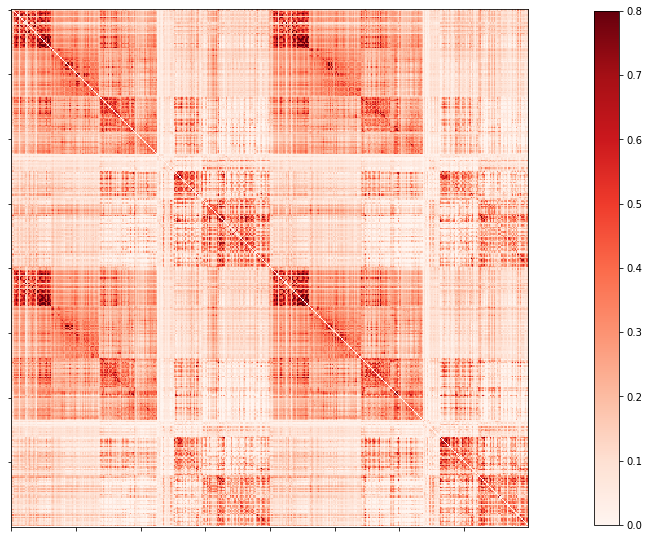

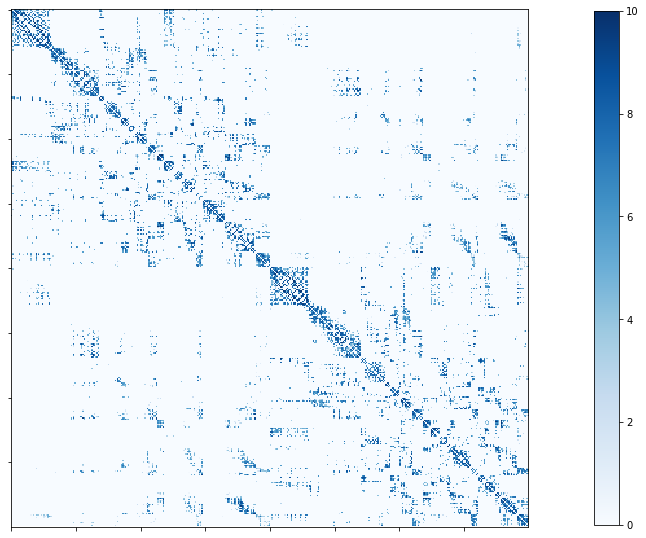

In [15]:
from enigmatoolbox.datasets import load_sc, load_fc

from nilearn import plotting

# Load cortico-cortical functional connectivity data

fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation=f'schaefer_{atlas_resolution}')

# Load cortico-cortical structural connectivity data

sc_ctx, sc_ctx_labels, _, _ = load_sc(parcellation=f'schaefer_{atlas_resolution}')

# Plot cortico-cortical connectivity matrices

fc_plot = plotting.plot_matrix(fc_ctx, figure=(9, 9), vmax=0.8, vmin=0, cmap='Reds')
fc_plot.write_png(output_dir/"functional_connectomes/fc_matrix.png")

sc_plot = plotting.plot_matrix(sc_ctx, figure=(9, 9), vmax=10, vmin=0, cmap='Blues')
sc_plot.write_png(output_dir/"structural_connectomes/sc_matrix.png")

# Implement plotting null distributions

In [16]:
def plot_null_distributions(p_and_d, rvals, color_dict):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, len(p_and_d.items()), figsize=(15, 3))

    if len(p_and_d.items()) == 1:

        for k, (fn, dd) in enumerate(p_and_d.items()):

            # Plot null distributions

            axs.hist(dd[1], bins=50, density=True, color=color_dict[fn], edgecolor='white', lw=0.5)

            axs.axvline(rvals[fn], lw=1.5, ls='--', color='k', dashes=(2, 3),

                     label='$r_{{sp}}$={:.2f}'.format(rvals[fn]) + '\n$p_{{spin}}$={:.3f}'.format(dd[0]))

            axs.set_xlabel('Null correlations \n ({})'.format(fn))

            axs.set_ylabel('Density')

            axs.spines['top'].set_visible(False)

            axs.spines['right'].set_visible(False)

            axs.legend(loc=1, frameon=False)
    
    else:

        for k, (fn, dd) in enumerate(p_and_d.items()):

            # Plot null distributions

            axs[k].hist(dd[1], bins=50, density=True, color=color_dict[fn], edgecolor='white', lw=0.5)

            axs[k].axvline(rvals[fn], lw=1.5, ls='--', color='k', dashes=(2, 3),

                        label='$r_{{sp}}$={:.2f}'.format(rvals[fn]) + '\n$p_{{spin}}$={:.3f}'.format(dd[0]))

            axs[k].set_xlabel('Null correlations \n ({})'.format(fn))

            axs[k].set_ylabel('Density')

            axs[k].spines['top'].set_visible(False)

            axs[k].spines['right'].set_visible(False)

            axs[k].legend(loc=1, frameon=False)

    fig.tight_layout()

    plt.show()

    return fig


# Implement scatter plots

In [17]:
def plot_scatter(meas, rvals, pvals, color_dict, cmap=None):

    import seaborn as sns
    import numpy as np

    fig, axs = plt.subplots(1, len(meas.items()), figsize=(15, 3))

    for k, (fn, dd) in enumerate(meas.items()):

        # Plot relationships

        axs[k].scatter(meas[fn][0], meas[fn][1], c=color_dict[fn[0]],
            
            label=f'$r_{{sp}}$={rvals[fn[0]]:.2f} \n$p_{{spin}}$={pvals[fn[0]]:.3f}', 
            
            cmap=cmap[k], edgecolors="black", linewidth=0.3)

        fin_idx = np.isfinite(meas[fn][0]) & np.isfinite(meas[fn][1])
        m, b = np.polyfit(meas[fn][0][fin_idx], meas[fn][1][fin_idx], 1)

        axs[k].plot(meas[fn][0], m * meas[fn][0] + b, color="lightgray")

        axs[k].set_xlabel('{}'.format(fn[0].capitalize()))

        axs[k].set_ylabel('{}'.format(fn[1].capitalize()))

        axs[k].spines['top'].set_visible(False)

        axs[k].spines['right'].set_visible(False)

        axs[k].legend(loc=1, frameon=False, markerscale=0)

    fig.tight_layout()

    plt.show()

    return fig

# Implement facilitated result retrieval from spin permutations  

In [18]:
def perform_spins(parc_meas1=None, parc_meas2=None, name_meas1=None, name_meas2=None, color_meas1=None, color_meas2=None):

    import numpy as np
    from scipy.stats import spearmanr, pearsonr
    from enigmatoolbox.permutation_testing import spin_test, shuf_test

    # Perform spatial correlations


    r_meas1 = spearmanr(parc_meas1, thickness_beta_schaefer, nan_policy="omit")[0]
    p_meas1, d_meas1 = spin_test(parc_meas1, thickness_beta_schaefer, surface_name='fsa5', parcellation_name=f'schaefer_{atlas_resolution}',
                                type='spearman', n_rot=1000, null_dist=True)


    r_meas2 = spearmanr(parc_meas2, thickness_beta_schaefer, nan_policy="omit")[0]
    p_meas2, d_meas2 = spin_test(parc_meas2, thickness_beta_schaefer, surface_name='fsa5', parcellation_name=f'schaefer_{atlas_resolution}',
                                type='spearman', n_rot=1000, null_dist=True)

    # Store plotting information

    rvals = {name_meas1 : r_meas1,
                name_meas2 : r_meas2}

    pvals = {name_meas1 : p_meas1,
                name_meas2 : p_meas2}

    p_and_d = {name_meas1 : [p_meas1, d_meas1],
                name_meas2 : [p_meas2, d_meas2]}

    color = {name_meas1 : color_meas1,
                name_meas2: color_meas2}

    color_gradient = {name_meas1 : parc_meas1,
                        name_meas2 : parc_meas2}

    return rvals, pvals, p_and_d, color, color_gradient

# Hub susceptibility

## Identify cortical hubs

In [20]:
import numpy as np

from enigmatoolbox.plotting import plot_cortical

from enigmatoolbox.utils.parcellation import parcel_to_surface

In [ ]:
# Compute weighted degree centrality measures from the connectivity data

fc_ctx_dc = np.sum(fc_ctx, axis=0)
sc_ctx_dc = np.sum(sc_ctx, axis=0)

fc_ctx_dc_rank = np.argsort(np.argsort(fc_ctx_dc * -1))
sc_ctx_dc_rank = np.argsort(np.argsort(sc_ctx_dc * -1))

# Project the results on the surface brain

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_dc_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_degree.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_dc_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_degree.png")

In [77]:
def calculate_participation_coefficient(conn_df):

    yeo_networks = ["Vis","SomMot","DorsAttn", "VentAttn", "Limbic", "Cont", "Default"]

    conn_df_degree = conn_df.sum(axis=0)
    rois = conn_df.columns

    PC_array = []

    for roi in rois:

        network_array = []
        for network in yeo_networks:
            
            roi_degree = conn_df_degree[roi]
            
            network_rois = [roi for roi in rois if network in roi]
            roi_to_network_df = conn_df.loc[roi,network_rois]

            roi_to_network_connectivity = roi_to_network_df.sum()

            network_array = np.append(network_array, (roi_to_network_connectivity / roi_degree) ** 2)

        PC_array = np.append(PC_array, (1 - network_array.sum()))

    return PC_array

fc_ctx_df = pd.DataFrame(fc_ctx, index=fc_ctx_labels, columns=fc_ctx_labels)
sc_ctx_df = pd.DataFrame(sc_ctx, index=sc_ctx_labels, columns=sc_ctx_labels)

fc_ctx_pc = calculate_participation_coefficient(conn_df=fc_ctx_df)
sc_ctx_pc = calculate_participation_coefficient(conn_df=sc_ctx_df)

fc_ctx_pc_rank = np.argsort(np.argsort(fc_ctx_pc))
sc_ctx_pc_rank = np.argsort(np.argsort(sc_ctx_pc))

# Project the results on the surface brain

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_pc_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_pc.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_pc_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_pc.png")

In [78]:
fc_ctx_hub_rank = np.argsort(np.argsort(fc_ctx_dc_rank + fc_ctx_pc_rank))
sc_ctx_hub_rank = np.argsort(np.argsort(sc_ctx_dc_rank + sc_ctx_pc_rank))

img = plot_cortical(array_name=parcel_to_surface(fc_ctx_hub_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/fc_hubs.png")

img = plot_cortical(array_name=parcel_to_surface(sc_ctx_hub_rank + 1, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Blues', color_bar=True, color_range=(1,atlas_resolution), embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/hub_atrophy/sc_hubs.png")

# Hub atrophy correlations

In [79]:
# Store degree centrality and atrophy measures

meas = {('functional hubness', r'$\beta$ age'): [fc_ctx_hub_rank, thickness_beta_schaefer],

        ('structural hubness', r'$\beta$ age'): [sc_ctx_hub_rank, thickness_beta_schaefer],
}


rvals, pvals, p_and_d, color, color_gradient = perform_spins(
    parc_meas1 = fc_ctx_hub_rank, 
    parc_meas2 = sc_ctx_hub_rank,
    name_meas1 = 'functional hubness',
    name_meas2 = 'structural hubness',
    color_meas1 = '#A8221C',
    color_meas2 = '#324F7D')

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


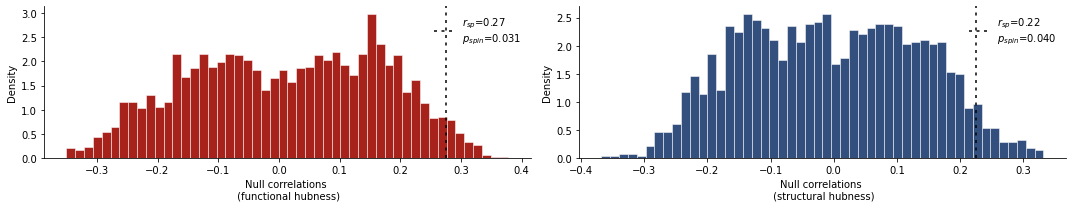

In [34]:
fig = plot_null_distributions(p_and_d, rvals, color)
fig.savefig(output_dir/"spatial_correlations/thickbeta_hubness_null.png", dpi=300)

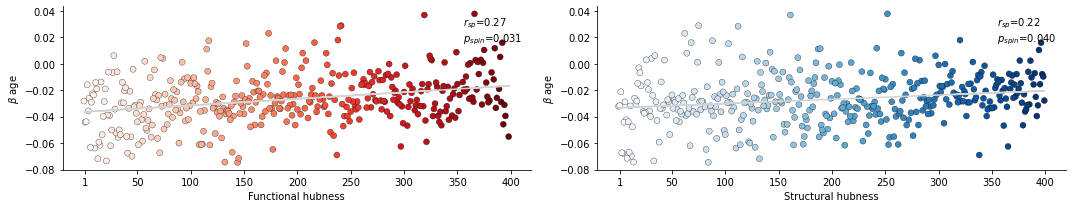

In [67]:
fig = plot_scatter(meas, rvals, pvals, color_dict=color_gradient, cmap=['Reds','Blues'])
fig.savefig(output_dir/"spatial_correlations/thickbeta_hubness.png", dpi=300)

# Neighborhood atrophy

In [83]:
def neighborhood(adjacency, metric, atlas_labels):

    nghbr_dict = {}

    for i in range(adjacency.shape[0]):

        mask_connected_nodes = adjacency[i] != 0
        n_connected_nodes = len(adjacency[i][mask_connected_nodes])

        weighted_measure_list = []

        for j in range(adjacency.shape[1]):

            if adjacency[i,j] != 0: weighted_measure_list.append(metric[j] * adjacency[i,j])

        weighted_measure_array = np.array(weighted_measure_list)
        sum_weighted_measure = sum(weighted_measure_array[~np.isnan(weighted_measure_array)])

        nghbr_dict[atlas_labels[i]] = sum_weighted_measure / n_connected_nodes
        
    return np.array(list(nghbr_dict.values()))

In [84]:
from enigmatoolbox.plotting import plot_cortical

nghbr_fc_schaefer = neighborhood(fc_ctx, thickness_beta_schaefer, fc_ctx_labels)
nghbr_sc_schaefer = neighborhood(sc_ctx, thickness_beta_schaefer, sc_ctx_labels)

plot_cortical(array_name=parcel_to_surface(nghbr_fc_schaefer, f'schaefer_{atlas_resolution}_conte69'), 
                surface_name="conte69", size=(800, 200),
                cmap='Reds_r', color_bar=True, embed_nb=True, 
                interactive=True, transparent_bg=False, nan_color=(211,211,211,1), screenshot=True,
                filename=f"{output_dir}/neighborhood/fc_neighborhood.png")

plot_cortical(array_name=parcel_to_surface(nghbr_sc_schaefer, f'schaefer_{atlas_resolution}_conte69'), 
                surface_name="conte69", size=(800, 200),
                cmap='Blues_r', color_bar=True, embed_nb=True, 
                interactive=True, transparent_bg=False, nan_color=(211,211,211,1), screenshot=True,
                filename=f"{output_dir}/neighborhood/sc_neighborhood.png")

'/media/marvin/seagate_2tb/CSI_HCHS/2021_petersen_ageing_atrophy_connectomics/output/neighborhood/sc_neighborhood.png'

In [21]:
meas1 = 'Functional connectivity-defined mean neighborhood thickness alteration'
meas2 = 'Structural connectivity-defined mean neighborhood thickness alteration'

meas = {(meas1, r'$\beta$ Age'): [nghbr_fc_schaefer, thickness_beta_schaefer],

        (meas2, r'$\beta$ Age'): [nghbr_sc_schaefer, thickness_beta_schaefer],
}

In [22]:
rvals, pvals, p_and_d, color, color_gradient = perform_spins(
    parc_meas1 = nghbr_fc_schaefer, 
    parc_meas2 = nghbr_sc_schaefer,
    name_meas1 = meas1,
    name_meas2 = meas2,
    color_meas1 = '#A8221C',
    color_meas2 = '#324F7D')

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


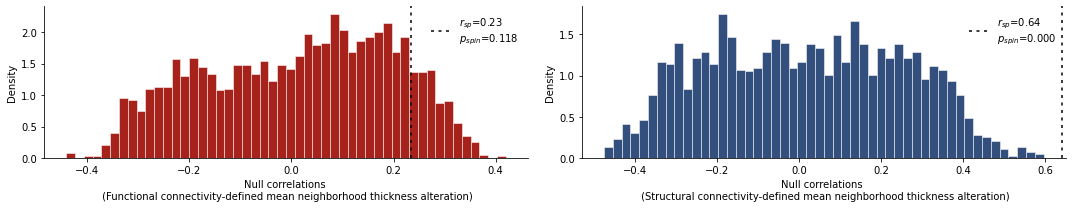

In [23]:
fig = plot_null_distributions(p_and_d, rvals, color)
fig.savefig(output_dir/"spatial_correlations/thickbeta_neighbor_null.png", dpi=300)

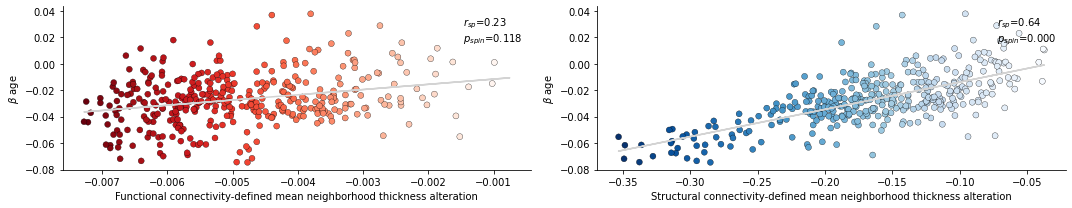

In [24]:
fig = plot_scatter(meas, rvals, pvals, color_dict=color_gradient, cmap=["Reds_r", "Blues_r"])
fig.savefig(output_dir/"spatial_correlations/thickbeta_neighbor.png", dpi=300)

# Gradient analysis

In [23]:
from brainspace.datasets import load_parcellation, load_conte69

# Load Schaefer parcellation mapping to conte69
labeling = load_parcellation('schaefer', scale=atlas_resolution, join=True)

# and load the conte69 surfaces
surf_lh, surf_rh = load_conte69()

## Functional gradient mapping

In [24]:
from brainspace.gradient import GradientMaps

gm = GradientMaps(n_components=10, random_state=0)
gm.fit(fc_ctx)

/home/marvin/miniconda3/lib/python3.9/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps(random_state=0)

In [25]:
import numpy as np
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

mask = labeling != 0

fc_grad = [None] * 2
for i in range(2):
    # map the gradient to the parcels
    fc_grad[i] = map_to_labels(gm.gradients_[:, i], labeling, mask=mask, fill=np.nan)

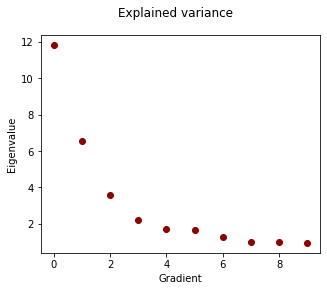

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_, color="darkred")
ax.set_xlabel('Gradient')
ax.set_ylabel('Eigenvalue')

fig.suptitle("Explained variance")

plt.savefig(output_dir/"gradients/eigenvalues_funcgrad.png")
plt.show()

## Functional gradient atrophy correlations

In [ ]:
fc_grad1_schaefer = surface_to_parcel(fc_grad[0], f'schaefer_{atlas_resolution}_conte69')[1:]
fc_grad2_schaefer = surface_to_parcel(fc_grad[1], f'schaefer_{atlas_resolution}_conte69')[1:]

img = plot_cortical(array_name=parcel_to_surface(fc_grad1_schaefer, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/gradients/functional_gradient1.png")
img = plot_cortical(array_name=parcel_to_surface(fc_grad2_schaefer, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Reds', color_bar=True, embed_nb=True, interactive=False, transparent_bg=False, 
              screenshot=True, filename=f"{output_dir}/gradients/functional_gradient2.png")

In [22]:
meas1 = 'functional connectivity gradient 1'
meas2 = 'functional connectivity gradient 2'

meas = {(meas1, r'$\beta$ Age'): [fc_grad1_schaefer, thickness_beta_schaefer],

        (meas2, r'$\beta$ Age'): [fc_grad2_schaefer, thickness_beta_schaefer],
}

In [31]:
rvals, pvals, p_and_d, color, color_gradient = perform_spins(
    parc_meas1 = fc_grad1_schaefer, 
    parc_meas2 = fc_grad2_schaefer,
    name_meas1 = meas1,
    name_meas2 = meas2,
    color_meas1 = '#A8221C',
    color_meas2 = '#A8221C')

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


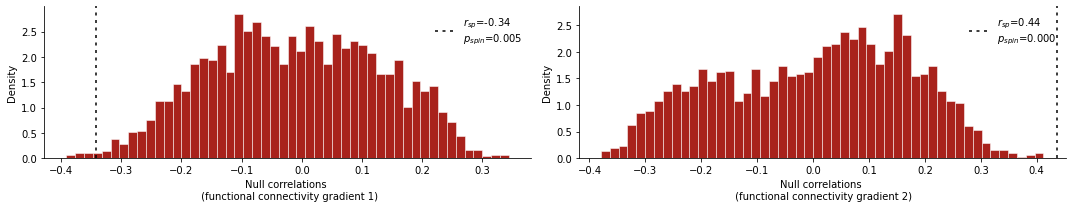

In [32]:
fig = plot_null_distributions(p_and_d, rvals, color)
fig.savefig(output_dir/"spatial_correlations/thickbeta_funcgrad_null.png", dpi=300)

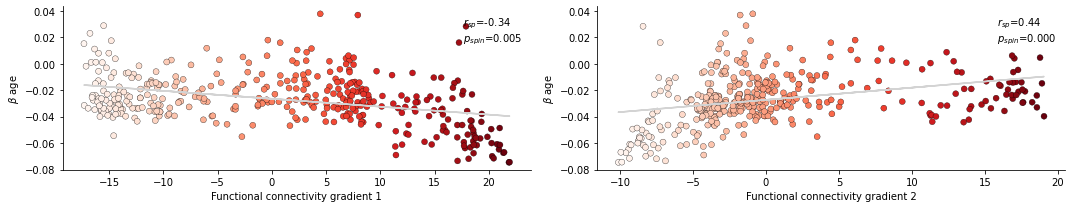

In [33]:
fig = plot_scatter(meas, rvals, pvals, color_dict=color_gradient, cmap=["Reds", "Reds"])
fig.savefig(output_dir/"spatial_correlations/thickbeta_funcgrad.png", dpi=300)

In [27]:
_10perc_quantile = np.nanquantile(thickness_beta_schaefer, 0.1)
thickness_beta_schaefer_nona = np.nan_to_num(thickness_beta_schaefer)

upper_10perc_quantile = np.nanquantile(thickness_beta_schaefer, 0.9)
thickness_beta_schaefer_10perc = thickness_beta_schaefer_nona.copy()
thickness_beta_schaefer_10perc[thickness_beta_schaefer_nona > _10perc_quantile] = 0
thickness_beta_schaefer_u10perc = thickness_beta_schaefer_nona.copy()
thickness_beta_schaefer_u10perc[thickness_beta_schaefer_nona < upper_10perc_quantile] = 0

fc_grad1_schaefer_10perc = fc_grad1_schaefer.copy()
fc_grad1_schaefer_10perc[thickness_beta_schaefer_nona > _10perc_quantile] = np.nan
fc_grad1_median_10perc = np.nanmedian(fc_grad1_schaefer_10perc)
fc_grad1_schaefer_u10perc = fc_grad1_schaefer.copy()
fc_grad1_schaefer_u10perc[thickness_beta_schaefer_nona < upper_10perc_quantile] = np.nan
fc_grad1_median_u10perc = np.nanmedian(fc_grad1_schaefer_u10perc)

fc_grad2_schaefer_10perc = fc_grad2_schaefer.copy()
fc_grad2_schaefer_10perc[thickness_beta_schaefer_nona > _10perc_quantile] = np.nan
fc_grad2_median_10perc = np.nanmedian(fc_grad2_schaefer_10perc)
fc_grad2_schaefer_u10perc = fc_grad2_schaefer.copy()
fc_grad2_schaefer_u10perc[thickness_beta_schaefer_nona < upper_10perc_quantile] = np.nan
fc_grad2_median_u10perc = np.nanmedian(fc_grad2_schaefer_u10perc)

print(f"Gradient 1 location of thinning maximum: {fc_grad1_median_10perc:.4f}; Gradient 2 location of thinning maximum: {fc_grad2_median_10perc:.4f}")
print(f"Gradient 1 location of thinning minimum: {fc_grad1_median_u10perc:.4f}; Gradient 2 location of thinning maximum: {fc_grad2_median_u10perc:.4f}")

Gradient 1 location of thinning maximum: 18.2263; Gradient 2 location of thinning maximum: -7.7745
Gradient 1 location of thinning minimum: -5.9949; Gradient 2 location of thinning maximum: -0.7748


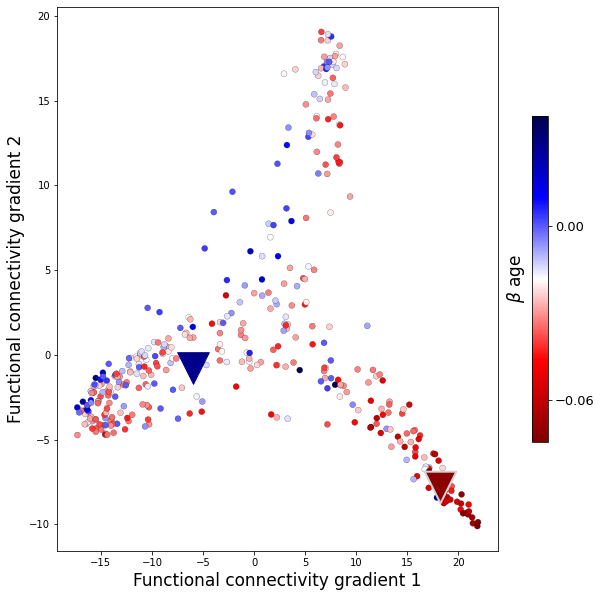

In [43]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib import ticker

orig_map=plt.cm.get_cmap('seismic')
reversed_map = orig_map.reversed()

fig, axs = plt.subplots(1, figsize=(10,10))

axs.scatter(fc_grad1_schaefer, fc_grad2_schaefer, 
    c=thickness_beta_schaefer, cmap=reversed_map,
    edgecolor='black', lw=0.2)
axs.set_xlabel("Functional connectivity gradient 1", size=17)
axs.set_ylabel("Functional connectivity gradient 2", size=17)
axs.scatter(fc_grad1_median_10perc, fc_grad2_median_10perc, s=1000, marker="v", color="darkred", edgecolors='lightgray', linewidth=2)
axs.scatter(fc_grad1_median_u10perc, fc_grad2_median_u10perc, s=1000, marker="v", color="darkblue")
normalize = mcolors.Normalize(vmin=np.min(thickness_beta_schaefer), 

    vmax=np.max(thickness_beta_schaefer))
s_map = cm.ScalarMappable(norm=normalize, cmap=reversed_map)
cbar = axs.figure.colorbar(s_map, shrink=0.6, pad=0.06)
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'$\beta$ age', labelpad=-90, size=17)
tick_locator = ticker.MaxNLocator(nbins=2)
cbar.locator = tick_locator
cbar.update_ticks()

fig.savefig(f"{output_dir}/gradients/gradient_plot.png", dpi=300)